In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import logging
from eden.util import configure_logging
configure_logging(logging.getLogger(), verbosity=1)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from eden.util.NeedlemanWunsh import edit_distance

def select_best_match(motives, orig_motives):
    for i, orig_motif in enumerate(orig_motives):
        max_score = 0
        max_cluster_id = 0
        max_motif = None
        for cluster_id in motives:
            consensus_seq = motives[cluster_id]['consensus_seq']
            score = edit_distance(orig_motif, consensus_seq)
            score = 2 * float(score) / (len(orig_motif)+len(consensus_seq))
            if score > max_score:
                max_score = score
                max_cluster_id = cluster_id
        yield max_score, max_cluster_id

In [18]:
% matplotlib inline
import pylab as plt 
import numpy as np
from sklearn.metrics import roc_auc_score

def plot_cumulative_score(smod, pos_seqs, sequence_length=None, motif_length=None):
    sig = None
    for scores in smod.score(pos_seqs):
        if sig is None:
            sig = np.array(scores)
        else:
            sig += np.array(scores)
    sig=np.array(sig)
    
    truth = np.zeros(len(sig))
    truth[sequence_length/2-motif_length/2:sequence_length/2+motif_length/2]=1
    roc = roc_auc_score(truth, sig)
    print 'Cumulative score ROC: %.2f' % roc


    plt.figure(figsize=(16,3))
    sigp = np.copy(sig)
    sigp[sigp<0]=0
    plt.bar(range(len(sigp)), sigp, alpha=0.3, color='g')
    sign = np.copy(sig)
    sign[sign>=0]=0
    plt.bar(range(len(sign)), sign, alpha=0.3, color='r')
    plt.plot((sequence_length/2-motif_length/2, sequence_length/2-motif_length/2), (min(sig), max(sig)), 'k-', lw=4)
    plt.plot((sequence_length/2+motif_length/2, sequence_length/2+motif_length/2), (min(sig), max(sig)), 'k-', lw=4)
    plt.xticks(range(len(sig)))
    plt.grid()
    plt.show()

In [19]:
#code for making artificial dataset
import random
import  numpy as np

def random_string(length,alphabet_list):
    rand_str = ''.join(random.choice(alphabet_list) for i in range(length))
    return rand_str

def perturb(seed,alphabet_list,perturbation_prob=0.5):
    seq=''
    for c in seed:
        if random.random() < perturbation_prob: 
            c = random.choice(alphabet_list)
        seq += c
    return seq

def create_motives(alphabet='ACGU', motif_length=10):
    motives = []
    for character in alphabet:
        motif = [character]*motif_length
        motives.append(''.join(motif))
    return motives

def make_artificial_dataset(alphabet='ACGU', 
                            motif_length=10,
                            sequence_length=100, 
                            n_sequences=1000, 
                            n_motives=2, 
                            perturbation_prob=0.2):
    alphabet_list=[c for c in alphabet]
    motives = [random_string(motif_length, alphabet_list) for i in range(n_motives)]
        
    flanking_length = (sequence_length - motif_length ) / 2
    n_seq_per_motif = n_sequences / n_motives

    counter=0
    seqs=[]
    targets=[]
    for i in range(n_seq_per_motif):
        for j in range(n_motives):
            left_flanking = random_string(flanking_length,alphabet_list)
            right_flanking = random_string(flanking_length,alphabet_list)
            noisy_motif = perturb(motives[j],alphabet_list,perturbation_prob)
            seq = left_flanking + noisy_motif + right_flanking
            seqs.append(('ID_%.3d'%counter,seq))
            targets.append(j)
            counter += 1
    return seqs, np.array(targets), motives

In [20]:
motif_length=6
n_motives=3
sequence_length=500
n_sequences=2000*n_motives
perturbation_prob=0.2

pos_seqs, targets, orig_motives = make_artificial_dataset('ACGU',motif_length,sequence_length,n_sequences,n_motives,perturbation_prob)

In [21]:
from eden.modifier.seq import seq_to_seq, shuffle_modifier
neg_seqs = seq_to_seq(pos_seqs, modifier=shuffle_modifier, times=2, order=1)
neg_seqs = list(neg_seqs)

In [22]:
complexity=3
n_clusters=n_motives*5
min_subarray_size=motif_length-2
max_subarray_size=motif_length+2
pos_block_size=len(pos_seqs)/8
neg_block_size=len(neg_seqs)/8

In [23]:
print 'motif_length:',motif_length
print 'n_motives:',n_motives
print 'sequence_length:',sequence_length
print 'n_sequences:',n_sequences
print 'perturbation_prob:',perturbation_prob

print 'n_clusters:',n_clusters
print 'min_subarray_size:',min_subarray_size
print 'max_subarray_size:',max_subarray_size
print 'pos block_size:',pos_block_size
print 'neg block_size:',neg_block_size

print
for motif in orig_motives: print motif

motif_length: 6
n_motives: 3
sequence_length: 500
n_sequences: 6000
perturbation_prob: 0.2
n_clusters: 15
min_subarray_size: 4
max_subarray_size: 8
pos block_size: 750
neg block_size: 1500

CAUUGC
CCGGUU
GAGAAG


Examples:

Cluster: 0
CAUUGC UGUACAGGACGGAUAGCAGUUGGCCACAUUGUUUGAUCCAGAAGGGACAUUGCACGCCAUUUUCUACAGGUGCGCGGGGCCGCGACCGUCCUUUUGGUGG
CAGUGA UUGUAUAGUCGGCUUUCGGUUUUUACACAUUUAAUAACAGUACGAACCAGUGACGCUCAGCCGAAGUACAGCGCUCACGCGAGGUAUACCGUGCAUGAGU
GAUUUC CUCGGGCUGAAGACCUGCGUCCGGAAUAUUGUUGGUGAGAUAUCGCCGAUUUCGUGCACGGAAAGCAAGGCUUAAUGAGAAUUAAUGGAAAAGGUGGUAG
CAUUGC CCCAACGGUUAUAGGAUCUUGGUGGACUCGUUUAAUUAAGUGGGCCCCAUUGCUCAAUCUUCAGGUUACUGUGCUACAUUACUUAGUUGUGAAAAAAUGA
AAUUGC UACCCAGGCUGUAUCACAUGUGGACAGGAUGCGUGAGAUGCAUGCGCAAUUGCUUUAUUAAAGCCCACGGGAGAAUUUGCUCACCUAUCGCUCGCAAACA
CUUUGC GGAGGUGAAUACAGAGUGGACGGGCAAUACACGCAAAGCUCAAAGUUCUUUGCGGGCACCCCAGGUUAACUCUAGCGUUGUAUUGAACCACAACGGAACA

Cluster: 1
CCGGUU GACGGCUUUUCCCACCGCUUAAUCGAUGGUCCUGUAUUUCCCUAAUGCCGGUUGUUUGUGUUUGAACUCGCUUUCCAACUGCCGGAGGGGAAAGGCACCU
CUGGUU CGGUAGUUACAACCGCUGCUGGAAGUACGUGAAGUCUCCGGGCACAGCUGGUUGAUAGCGCGCGAUACUUGGUACUCACAAAUAGUAAGCGCAAUGACAG
GCUGUU UACGUGCCGACGGCAAGUUAAAGUAAGGUGAGACGUAUCGUGGAGAGGCUGUUGACCGUGGCACUAUAGUUUGGUCCUGUUGUUUUCGUCCCCGG

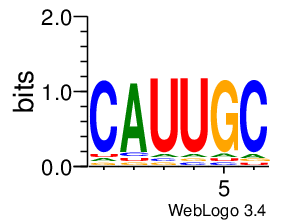

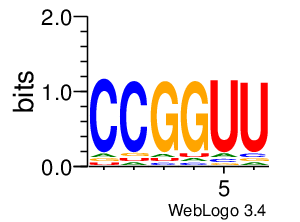

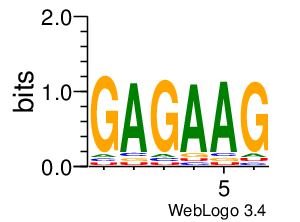

In [24]:
print 'Examples:'

max_chars=50
for id_clus in range(n_motives):
    print 
    print 'Cluster: %d' % id_clus
    for i,( h,s) in enumerate(pos_seqs[:16]):
        id = i % n_motives
        if id == id_clus:
            print s[sequence_length/2-motif_length/2:sequence_length/2+motif_length/2], s[sequence_length/2-max_chars:sequence_length/2+max_chars]

            
from collections import defaultdict

true_motives = defaultdict(list)
for i,( h,s) in enumerate(pos_seqs):
    id = i % n_motives
    true_motives[id].append((h,s[sequence_length/2-motif_length/2:sequence_length/2+motif_length/2]))
from eden.sequence_motif_decomposer import Weblogo
wl= Weblogo(resolution=200,stacks_per_line=60, sequence_type='rna')

for id in true_motives:
    logo = wl.create_logo(true_motives[id])
    from IPython.display import Image, display
    display(Image(logo))

Identified a total of 2 motives
Average score: 0.65


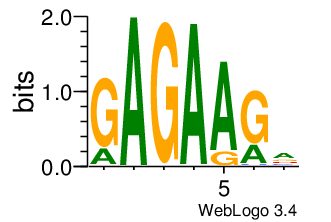

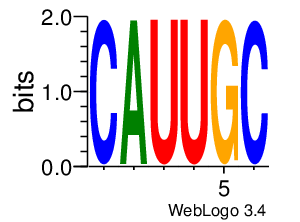

CPU times: user 5.25 s, sys: 1.37 s, total: 6.62 s
Wall time: 13min 53s


In [25]:
%%time
pos_size = len(pos_seqs)
train_pos_seqs = pos_seqs[:pos_size/2]
test_pos_seqs = pos_seqs[pos_size/2:]

neg_size = len(neg_seqs)
train_neg_seqs = neg_seqs[:neg_size/2]
test_neg_seqs = neg_seqs[neg_size/2:]

from eden.sequence_motif_decomposer import SequenceMotifDecomposer as SMoD
smod=SMoD(complexity=complexity,
          n_clusters=n_clusters,
          min_subarray_size=min_subarray_size,
          max_subarray_size=max_subarray_size,
          pos_block_size=pos_block_size,
          neg_block_size=neg_block_size)
smod = smod.fit(train_pos_seqs, train_neg_seqs)
motives = smod.select_motives(seqs=pos_seqs,
                                p_value=0.05,
                                similarity_th=0.5,
                                min_score=4,
                                min_freq=.5,
                                min_cluster_size=5,
                                regex_th=.3,
                                sample_size=200,
                                freq_th=None,
                                std_th=None)
print 'Identified a total of %d motives' % len(motives)
avg_score = np.mean([s for s,id in select_best_match(motives, orig_motives)])
print 'Average score: %.2f' % avg_score

selected = [id for s,id in select_best_match(motives, orig_motives)]
logos = smod.compute_logos(motives,ids=selected)
for id in logos:
    from IPython.display import Image, display
    display(Image(logos[id]))

# Full analysis

Confusion matrix:
[[5319  681]
 [2477  523]]
Classification:
             precision    recall  f1-score   support

         -1       0.68      0.89      0.77      6000
          1       0.43      0.17      0.25      3000

avg / total       0.60      0.65      0.60      9000

ROC: 0.573
Cumulative score ROC: 1.00


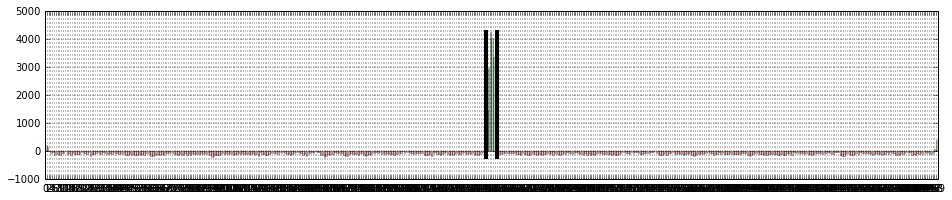

CPU times: user 16.2 s, sys: 2.18 s, total: 18.4 s
Wall time: 24min 37s


In [26]:
%%time

pos_size = len(pos_seqs)
train_pos_seqs = pos_seqs[:pos_size/2]
test_pos_seqs = pos_seqs[pos_size/2:]

neg_size = len(neg_seqs)
train_neg_seqs = neg_seqs[:neg_size/2]
test_neg_seqs = neg_seqs[neg_size/2:]

from eden.sequence_motif_decomposer import SequenceMotifDecomposer as SMoD
smod=SMoD(complexity=complexity,
          n_clusters=n_clusters,
          min_subarray_size=min_subarray_size,
          max_subarray_size=max_subarray_size,
          pos_block_size=pos_block_size,
          neg_block_size=neg_block_size)
smod = smod.fit(train_pos_seqs, train_neg_seqs)
smod.performance(test_pos_seqs, test_neg_seqs)
plot_cumulative_score(smod, test_pos_seqs, sequence_length=sequence_length, motif_length=motif_length)
motives = smod.select_motives(seqs=pos_seqs,
                                p_value=0.05,
                                similarity_th=0.5,
                                min_score=4,
                                min_freq=.5,
                                min_cluster_size=5,
                                regex_th=.3,
                                sample_size=200,
                                freq_th=None,
                                std_th=None)

In [28]:
from IPython import display
display.Markdown(data=smod.report(pos_seqs, motives, fname='motif'))

Motif id: 3
- num subarrays: 55
- consensus sequence: CCGGUUG
- consensus regex: CCGGUUG
- num occurrences of regex: 372
- freq of occurrences of regex: 0.06
- average location: 250.0 +- 11.5
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_logo_cl_3.png"></p>
<p align="left"><img src="motif_logo_cl_3.png"></p>
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_loc_3.png" style="width: 100%"></p>
<p align="left"><img src="motif_loc_3.png" style="width: 100%"></p>
- num co-occurences of motif 3 vs 0: 10
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_dist_3_vs_0.png" style="width: 100%"></p>
<p align="left"><img src="motif_dist_3_vs_0.png" style="width: 100%"></p>
- num co-occurences of motif 3 vs 1: 6
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_dist_3_vs_1.png" style="width: 100%"></p>
<p align="left"><img src="motif_dist_3_vs_1.png" style="width: 100%"></p>
- num co-occurences of motif 3 vs 11: 0
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_dist_3_vs_11.png" style="width: 100%"></p>
<p align="left"><img src="motif_dist_3_vs_11.png" style="width: 100%"></p>
____________________________________________________________________________________________________
Motif id: 0
- num subarrays: 1372
- consensus sequence: GGAGAAGG
- consensus regex: GAGAAGG
- num occurrences of regex: 363
- freq of occurrences of regex: 0.06
- average location: 250.0 +- 0.0
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_logo_cl_0.png"></p>
<p align="left"><img src="motif_logo_cl_0.png"></p>
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_loc_0.png" style="width: 100%"></p>
<p align="left"><img src="motif_loc_0.png" style="width: 100%"></p>
- num co-occurences of motif 0 vs 1: 110
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_dist_0_vs_1.png" style="width: 100%"></p>
<p align="left"><img src="motif_dist_0_vs_1.png" style="width: 100%"></p>
- num co-occurences of motif 0 vs 3: 10
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_dist_0_vs_3.png" style="width: 100%"></p>
<p align="left"><img src="motif_dist_0_vs_3.png" style="width: 100%"></p>
- num co-occurences of motif 0 vs 11: 2
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_dist_0_vs_11.png" style="width: 100%"></p>
<p align="left"><img src="motif_dist_0_vs_11.png" style="width: 100%"></p>
____________________________________________________________________________________________________
Motif id: 1
- num subarrays: 797
- consensus sequence: GCAUUGCC
- consensus regex: CAUUGCC
- num occurrences of regex: 344
- freq of occurrences of regex: 0.06
- average location: 250.0 +- 22.5
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_logo_cl_1.png"></p>
<p align="left"><img src="motif_logo_cl_1.png"></p>
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_loc_1.png" style="width: 100%"></p>
<p align="left"><img src="motif_loc_1.png" style="width: 100%"></p>
- num co-occurences of motif 1 vs 0: 110
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_dist_1_vs_0.png" style="width: 100%"></p>
<p align="left"><img src="motif_dist_1_vs_0.png" style="width: 100%"></p>
- num co-occurences of motif 1 vs 3: 6
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_dist_1_vs_3.png" style="width: 100%"></p>
<p align="left"><img src="motif_dist_1_vs_3.png" style="width: 100%"></p>
- num co-occurences of motif 1 vs 11: 2
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_dist_1_vs_11.png" style="width: 100%"></p>
<p align="left"><img src="motif_dist_1_vs_11.png" style="width: 100%"></p>
____________________________________________________________________________________________________
Motif id: 11
- num subarrays: 26
- consensus sequence: AACCGGUU
- consensus regex: AACCGGUU
- num occurrences of regex: 102
- freq of occurrences of regex: 0.02
- average location: 249.0 +- 27.0
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_logo_cl_11.png"></p>
<p align="left"><img src="motif_logo_cl_11.png"></p>
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_loc_11.png" style="width: 100%"></p>
<p align="left"><img src="motif_loc_11.png" style="width: 100%"></p>
- num co-occurences of motif 11 vs 0: 2
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_dist_11_vs_0.png" style="width: 100%"></p>
<p align="left"><img src="motif_dist_11_vs_0.png" style="width: 100%"></p>
- num co-occurences of motif 11 vs 1: 2
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_dist_11_vs_1.png" style="width: 100%"></p>
<p align="left"><img src="motif_dist_11_vs_1.png" style="width: 100%"></p>
- num co-occurences of motif 11 vs 3: 0
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_dist_11_vs_3.png" style="width: 100%"></p>
<p align="left"><img src="motif_dist_11_vs_3.png" style="width: 100%"></p>
____________________________________________________________________________________________________

---